In [118]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-vwppepfo
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-vwppepfo
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=dbe17b1686748085722e96efab154b5524843e36ba88a65e17d82c48d83a0ee6
  Stored in directory: /tmp/pip-ephem-wheel-cache-tgvsxf8z/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [119]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from random import random
from numpy.random import randint

In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
!ls /content/drive/MyDrive

 AFF
 AIBlackjack_conceptual.drawio
 app-ard-rasp.drawio
 app-raspochard.drawio
 architecture.drawio
 aTack-design.drawio
'Beta testers list.gsheet'
'Beta test sign up.gform'
'Beta test sign up (Svar).gsheet'
 bobross
'brainstorm cost estimation.gdoc'
 colabdrive
'Colab Notebooks'
'combitech orga.drawio'
'Conceptual Design.gdraw'
'Consid event.drawio'
'context diagram reworked.drawio'
 ContinuousSwiping.drawio
 cyclegan
 cyclegan_progress
 EBMC
 E-challenge
'email concept.drawio'
'Files Architecture.drawio'
 FLRS_App.drawio
'Freddes Concepts.drawio'
 IMDB_reviews.json.zip
 img10.jpg
 img11.jpg
 img12.jpg
 img1.jpg
 img2.jpg
 img3.png
 img4.jpg
 img5.jpg
 img6.jpg
 img7.jpg
 img8.jpg
 img9.jpg
 Ingenium
'innebandy coachen'
 intraapp.drawio
'Kopia av rel3.jpg'
'Kopia av Swuzzle.gdoc'
'Kopia av User stories.docx'
'Kopia av User stories post pivot.docx'
'Mammas Receptbok'
 milestones.drawio
 MinecraftDay
'Möte 2018-10-02.gdoc'
'Namnlös teckning.gdraw'
'Namnlöst kalkylark.gsheet'
 NARMS_

In [122]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [123]:
def transform_resnet_block(nrOfFilters, inputLayer):
    init = keras.initializers.RandomNormal(stddev=0.02)
    resnet = keras.layers.Conv2D(nrOfFilters, (3,3), padding='same', kernel_initializer=init)(inputLayer)
    # instead of Batchnormalization
    resnet = InstanceNormalization(axis=-1)(resnet)
    resnet = keras.layers.Activation('relu')(resnet)
    # TODO reflection padding
    resnet = keras.layers.Conv2D(nrOfFilters, (3,3), padding='same', kernel_initializer=init)(resnet)
    resnet = InstanceNormalization(axis=-1)(resnet)
    resnet = keras.layers.Concatenate()([resnet, inputLayer])
    return resnet



In [124]:
# TODO generator model to use 6 ResNet layers as is used in the cycleGAN paper
def general_generator(imageShape=(256,256,3), nrOfResnet=9):
    init = keras.initializers.RandomNormal(stddev=0.02)
    inputImage = keras.Input(shape=imageShape)
    # ----Encode ------
    generator = keras.layers.Conv2D(64, (7,7), padding='same', kernel_initializer=init)(inputImage)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    # ----Transform -----
    for _ in range(nrOfResnet):
        generator = transform_resnet_block(256, generator)
    # ----Decode ------
    generator = keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2D(3, (7,7), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    outputImage = keras.layers.Activation('tanh')(generator)

    model = keras.Model(inputImage, outputImage)
    return model



In [125]:
# test creation of a generator
imageShape = (256,256, 3)
model = general_generator(imageShape)
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_438 (Conv2D)             (None, 256, 256, 64) 9472        input_22[0][0]                   
__________________________________________________________________________________________________
tf.math.reduce_mean_1467 (TFOpL (None, 1, 1, 64)     0           conv2d_438[0][0]                 
__________________________________________________________________________________________________
tf.math.reduce_std_489 (TFOpLam (None, 1, 1, 64)     0           conv2d_438[0][0]                 
___________________________________________________________________________________________

In [126]:
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

def general_discriminator(imageShape):
    init = RandomNormal(stddev=0.02)
    inputImage = Input(shape=imageShape)

    discriminator = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputImage)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    output = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(discriminator)
    model = Model(inputImage, output)
    # TODO negative log likelihood (e.g. binary cross entropy).
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model


In [127]:
# test creation of a discriminator
imageShape = (256,256, 3)
model = general_discriminator(imageShape)
model.summary()

Model: "model_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_105 (LeakyReLU)  (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization_588 ( (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_106 (LeakyReLU)  (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 32, 32, 256)       524

In [128]:
# Mean squared error, lambda 1
def adversarial_loss_model(generator, discriminator, imageShape):
    inputGenerator = Input(shape=imageShape)
    generatorOutput = generator(inputGenerator)
    outputDiscriminator = discriminator(generatorOutput)
    model = Model(inputGenerator, outputDiscriminator)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mse', loss_weights=[1], optimizer=opt)
    return model

# If something already looks like from the target domain, you should not map it into a different image.
#Identity loss says that, if you fed image Y to generator G, it should yield the real image Y or something close to image Y.
# Mean absolute error, lambda 5
def identity_loss_model(generator, imageShape):
    inputIdentity = Input(shape=imageShape)
    outputIdentity = generator(inputIdentity)
    model = Model(inputIdentity, outputIdentity)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mae', loss_weights=[5], optimizer=opt)
    return model

# Mean absolute error, lambda 10
def forward_cycle_loss_model(generatorG, generatorF, imageShape):
    inputGenerator = Input(shape=imageShape)
    generatorG_output = generatorG(inputGenerator)
    generatorF_output = generatorF(generatorG_output)
    model = Model(inputGenerator, generatorF_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mae', loss_weights=[10], optimizer=opt)
    return model

# Mean absolute error, lambda 10
def backward_cycle_loss_model(generatorG, generatorF, imageShape):
    inputGenerator = Input(shape=imageShape)
    generatorF_output = generatorF(inputGenerator)
    generatorG_output = generatorG(generatorF_output)
    model = Model(inputGenerator, generatorG_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mae', loss_weights=[10], optimizer=opt)
    return model


In [129]:
# test code creaton of models---
imageShape = (256,256, 3)
# generator G(x) -> y'
Gx_2_y = general_generator(imageShape)
# generator F(y') -> x'
Fy_2_x = general_generator(imageShape)
# discriminator D(y') -> real/fake painting?
Dy = general_discriminator(imageShape)
# discriminator D(x') -> real/fake landscape?
Dx = general_discriminator(imageShape)

adversarial_loss_model_G = adversarial_loss_model(Gx_2_y, Dy, imageShape)
identity_loss_model_G = identity_loss_model(Gx_2_y, imageShape)
forward_cycle_loss_model_G = forward_cycle_loss_model(Gx_2_y, Fy_2_x, imageShape)
backward_cycle_loss_model_G = backward_cycle_loss_model(Gx_2_y, Fy_2_x, imageShape)

adversarial_loss_model_F = adversarial_loss_model(Fy_2_x, Dx, imageShape)
identity_loss_model_F = identity_loss_model(Fy_2_x, imageShape)
forward_cycle_loss_model_F = forward_cycle_loss_model(Fy_2_x, Gx_2_y, imageShape)
backward_cycle_loss_model_F = backward_cycle_loss_model(Fy_2_x, Gx_2_y, imageShape)

print("disc a shape: ", Dy.output_shape)
adversarial_loss_model_G.summary()

The following Variables were used a Lambda layer's call (tf.nn.convolution_1761), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_460/kernel:0' shape=(7, 7, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1929), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_460/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1762), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_461/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that thi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


The following Variables were used a Lambda layer's call (tf.nn.convolution_1788), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_465/kernel:0' shape=(3, 3, 512, 256) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1958), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_465/bias:0' shape=(256,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1789), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_466/kernel:0' shape=(3, 3, 256, 256) dtype=float32>
It is possible tha

test image shpae:  (337, 450, 3)


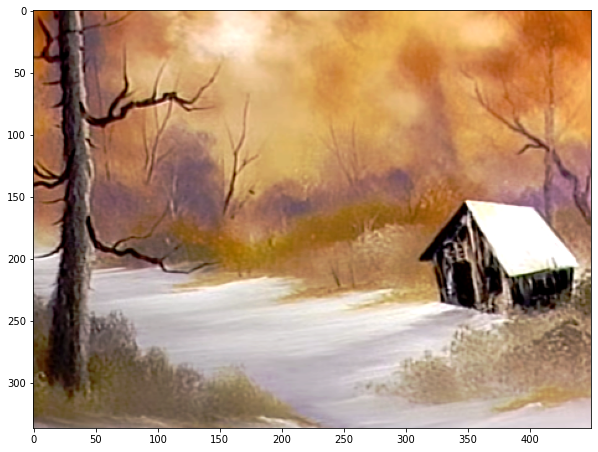

In [130]:
# sneak peak of a bob ross painting
# /content/drive/MyDrive/bobross/data/bobross_paintings/Y/painting5.png
from matplotlib import pyplot as plt
base_path_google_drive = '/content/drive/MyDrive/bobross'
test_image = cv.imread(base_path_google_drive + '/data/bobross_paintings/Y/painting5.png')
print("test image shpae: ", test_image.shape)
test_image_bgr = cv.cvtColor(test_image, cv.COLOR_RGB2BGR)
figure = plt.figure(figsize=(10,10))
plt.imshow(test_image_bgr)
plt.show()

In [131]:
def random_flip(image):
  image = tf.image.random_flip_left_right(image)

  return image

In [132]:
import os 
tfds_cache_dir = os.path.join(os.getcwd(),'tfds_cache')
os.makedirs(tfds_cache_dir, exist_ok = True)

img_height = 256
img_width = 256
data_dir_bob = base_path_google_drive+'/data/bobross_paintings'

#saving some images as validation to try the model when finished
# (i.e. so that i dont have to go to google and find new images)
# TODO quickfix to use the whole dataset as one batch
train_ds_bob = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_bob,
  validation_split=0.025,
  subset="training",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=393
)

val_ds_bob = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_bob,
  validation_split=0.025,
  subset="validation",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=10
)


Found 403 files belonging to 1 classes.
Using 393 files for training.
Found 403 files belonging to 1 classes.
Using 10 files for validation.


In [133]:
batch_size = 2
img_height = 256
img_width = 256
data_dir_landscapes = base_path_google_drive+'/data/landscape_pictures'

#saving some images as validation to try the model when finished
# (i.e. so that i dont have to go to google and find new images)
# TODO quickfix to use the whole dataset as one batch
train_ds_landscapes = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_landscapes,
  validation_split=0.025,
  subset="training",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=4212
)

val_ds_landscapes = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_landscapes,
  validation_split=0.025,
  subset="validation",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=107
)



AUTOTUNE = tf.data.AUTOTUNE
train_ds_bob = train_ds_bob.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#train_ds_bob = train_ds_bob.map(random_flip, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_ds_landscapes = train_ds_landscapes.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

'''
# make the datasets iterable
paintings_batches = iter(train_ds_bob)
landscapes_batches = iter(train_ds_landscapes)
'''
'''
first_image_batch, labels_batch = next(landscapes_batches)
first_image = first_image_batch[0]
print(first_image)
'''

Found 4319 files belonging to 1 classes.
Using 4212 files for training.
Found 4319 files belonging to 1 classes.
Using 107 files for validation.


'\nfirst_image_batch, labels_batch = next(landscapes_batches)\nfirst_image = first_image_batch[0]\nprint(first_image)\n'

In [134]:
#  image manipulation only by flipping horizontally.
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal")
])



In [135]:
# Only run this once to extract all the images and labels
batchSize = 16
nrOfTrainingEpochs = 100
paintings_ds = iter(train_ds_bob)
landscapes_ds = iter(train_ds_landscapes)
landscapes_val_ds = iter(val_ds_landscapes)
paintings, painting_labels = next(paintings_ds)
landscapes, landscape_labels = next(landscapes_ds)
landscapes_val, landscape_labels_val = next(landscapes_val_ds)

nrOfTrainingSteps = int(len(landscapes) / batchSize) * nrOfTrainingEpochs
print("training steps ::", nrOfTrainingSteps)

training steps :: 26300


In [136]:
print("shape paitings before normalization", paintings.shape)
# Normalize the datasets to [0,1] to give the models an easier time training

paintings /= 255
landscapes /= 255
print("shape images: ", images.shape)
print("shape paintings: ", paintings.shape)
print("p len", len(paintings), "p lab len", len(painting_labels))
print("land len", len(landscapes), "land lab len", len(landscape_labels))




shape paitings before normalization (393, 256, 256, 3)
shape images:  (393, 256, 256, 3)
shape paintings:  (393, 256, 256, 3)
p len 393 p lab len 393
land len 4212 land lab len 4212


In [137]:
# Make a batch of 16 st images and labels
# All real images should be labelled 1's
# TODO data generator that systematically works through each dataset instead of random sampling.
# This is a quick fix to train imbalanced datasets.
def create_random_batch(images, batchSize=2, discOutputShape=(None, 16, 16, 1)): #TODO make batchSize 16
    indexes = randint(0, len(images), batchSize)
    # retrieve selected images
    selectedImages = tf.gather(images, indexes)
    # genrate real class labels 1
    labels = tf.ones((batchSize, discOutputShape[1], discOutputShape[2], discOutputShape[3]), tf.int32)
    return selectedImages, labels

img shape (1, 256, 256, 3)


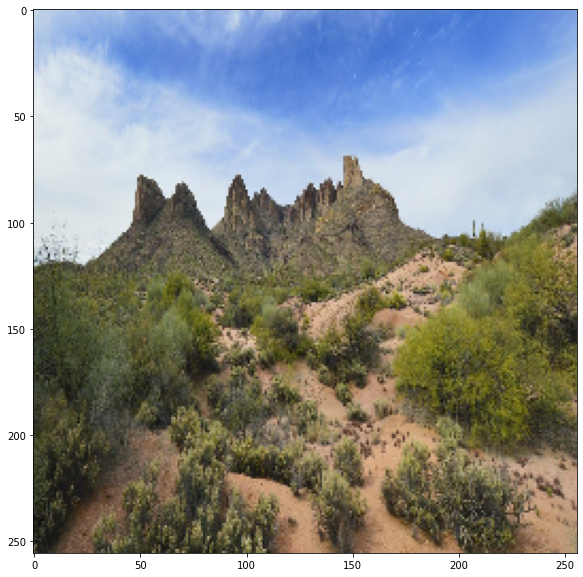

In [139]:
##TEST print landscape real image
img, img_label = create_random_batch(landscapes_val, batchSize=1)
print("img shape", img.shape)
img /= 255.
#real_image = (img + 1) / 2.0
real_image = tf.reshape(img, [256, 256, 3])
figure = plt.figure(figsize=(10,10))
plt.imshow(real_image)
plt.show()

In [140]:
print(paintings[0])

# TODO not optimal? deprecated
def make_labels_ones(tensorarray):
    tensor_array_of_ones = tf.ones((tf.size(tensorarray), 16, 16, 1), tf.int32)
    return tensor_array_of_ones 
#print(make_labels_ones(labelsBatchLandscapes))


tf.Tensor(
[[[0.24849877 0.2908165  0.47861046]
  [0.24776575 0.2908165  0.47360715]
  [0.23316833 0.27844954 0.45904848]
  ...
  [0.44313726 0.6751302  0.917723  ]
  [0.44313726 0.67459464 0.923629  ]
  [0.44313726 0.6745098  0.923629  ]]

 [[0.23529412 0.29411766 0.4745098 ]
  [0.23957992 0.29784006 0.47823223]
  [0.23945116 0.29599702 0.47823223]
  ...
  [0.44499847 0.6821538  0.91000307]
  [0.44499847 0.6771616  0.91000307]
  [0.44499847 0.67637104 0.9137255 ]]

 [[0.23529412 0.29411766 0.4745098 ]
  [0.24313726 0.3019608  0.48235294]
  [0.24313726 0.3019608  0.48235294]
  ...
  [0.45326287 0.69247854 0.91208637]
  [0.44790703 0.68570775 0.90673053]
  [0.45091212 0.686138   0.91330135]]

 ...

 [[0.623418   0.70406777 0.80245864]
  [0.63366926 0.7147737  0.81067115]
  [0.667949   0.7324919  0.83167785]
  ...
  [0.62255883 0.69966733 0.7849571 ]
  [0.6338811  0.70892227 0.7944058 ]
  [0.63722295 0.70245314 0.78170407]]

 [[0.6635417  0.7164386  0.82718515]
  [0.6614813  0.722955   0

In [141]:
# Imagepool based on: https://github.com/junyanz/CycleGAN/blob/master/util/image_pool.lua
# The paper defines an image pool of 50 generated images
# Returns only 1 generated image that the disciminator can calculate loss upon

def update_image_pool(pool, generatedImages, max_size=50):
	for image in generatedImages:
		if len(pool) < max_size:
			# append to pool
			pool.append(image)
			selectedImage = image
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selectedImage = image
		else:
			# replace an existing image and use the replaced image
			ix = randint(0, len(pool))
			selectedImage = pool[ix]
			pool[ix] = image
	return selectedImage

In [ ]:
# -----test Environment-------------
imageShape = (256,256, 3)
# generator G(x) -> y'
Gx2y = general_generator(imageShape)
# generator F(y') -> x'
Fy2x = general_generator(imageShape)
# discriminator D(y') -> real/fake painting?
Dy = general_discriminator(imageShape)
# discriminator D(x') -> real/fake landscape?
Dx = general_discriminator(imageShape)
poolG, poolF = list(), list()
batch_size = 2
discriminator_loss_size = 1
# Pass real images thorugh both generators & create labels as 0 representing generated images
'''
for i in range(35):
    nextBatchRealLandscapes, labelsBatchLandscapes = next(landscapes_batches)
    print("shape of image batch", nextBatchRealLandscapes.shape)
    yPrimeArr = Gx2y.predict(nextBatchRealLandscapes)
    print("shape of yprime prediction: ", yPrimeArr.shape)
    yPrimeArr = update_image_pool(poolG, yPrimeArr)
    yPrimeArr = tf.reshape(yPrimeArr, [discriminator_loss_size, 256, 256, 3])
    print("shape of yprime pool returned: ", yPrimeArr.shape)
    print("pool G size: ", len(poolG))
    yPrimeLabels = tf.zeros((discriminator_loss_size, 256,256,1), tf.int32)
    print("shape of yprime labels:: ", yPrimeLabels.shape)
    #print("yprime labels: Should be 0's: ", yPrimeLabels)

#y = ones((n_samples, patch_shape, patch_shape, 1))
'''

'\nfor i in range(35):\n    nextBatchRealLandscapes, labelsBatchLandscapes = next(landscapes_batches)\n    print("shape of image batch", nextBatchRealLandscapes.shape)\n    yPrimeArr = Gx2y.predict(nextBatchRealLandscapes)\n    print("shape of yprime prediction: ", yPrimeArr.shape)\n    yPrimeArr = update_image_pool(poolG, yPrimeArr)\n    yPrimeArr = tf.reshape(yPrimeArr, [discriminator_loss_size, 256, 256, 3])\n    print("shape of yprime pool returned: ", yPrimeArr.shape)\n    print("pool G size: ", len(poolG))\n    yPrimeLabels = tf.zeros((discriminator_loss_size, 256,256,1), tf.int32)\n    print("shape of yprime labels:: ", yPrimeLabels.shape)\n    #print("yprime labels: Should be 0\'s: ", yPrimeLabels)\n\n#y = ones((n_samples, patch_shape, patch_shape, 1))\n'

In [142]:
def plot_generate_to_painting(model, trainingStep):
    generated_images_dir = os.path.join(os.getcwd(),'generated_images')
    os.makedirs(generated_images_dir, exist_ok = True)
    img, img_label = create_random_batch(landscapes_val, batchSize=1)
    print("img shape", img.shape)

    img /= 255.
    img2 = (img + 1) / 2.0
    img2 = tf.reshape(img2, [1, 256, 256, 3])
    generated_test_image = model.predict(img2)
    real_image = (img + 1) / 2.0
    generated_test_image = generated_test_image.reshape((256,256,3))
    new_img_bgr = cv.cvtColor(generated_test_image, cv.COLOR_RGB2BGR)
    real_image = tf.reshape(real_image, [256, 256, 3])
    
    # Plot generated image
    plt.subplot(2, 1, 1)
    plt.axis('off')
    plt.imshow(new_img_bgr)
    # Plot real image
    plt.subplot(2, 1, 2)
    plt.axis('off')
    plt.imshow(real_image)
    
    driveFilename = base_path_google_drive + '/generated_images/generated_plot_e' + str(trainingStep) + '.png'
    #filename = 'generated_images/generated_plot_' + str(trainingStep) + '.png'
    plt.savefig(driveFilename)
    plt.close()

#plot_generate_to_painting(Gx2y, 55)
    
    

In [143]:
def save_models(modelG, modelF, trainingStep):
    generators_dir = os.path.join(os.getcwd(),'generators')
    os.makedirs(generators_dir, exist_ok = True)
    driveFilenameG = base_path_google_drive + '/generators/G_modele' + str(trainingStep) + '.h5'
    filename_model_G = 'generators/G_model' + str(trainingStep) + '.h5'
    modelG.save(driveFilenameG)
    driveFilenameF = base_path_google_drive + '/generators/F_modele' + str(trainingStep) + '.h5'
    filename_model_F = 'generators/F_model' + str(trainingStep) + '.h5'
    modelF.save(driveFilenameF)
    print('saved model G and F locally & on google drive')

In [144]:
def train(Gx2y, Fy2x, Dy, Dx):
    nrOfTrainingEpochs = 50 #TODO change to 100
    batchSize = 2 #TODO set to 16
    discriminator_loss_size = 1
    poolG, poolF = list(), list()
    nrOfTrainingSteps = int(len(landscapes) / batchSize) * nrOfTrainingEpochs

    adversarial_loss_model_G = adversarial_loss_model(Gx2y, Dy, imageShape)
    identity_loss_model_G = identity_loss_model(Gx2y, imageShape)
    forward_cycle_loss_model_G = forward_cycle_loss_model(Gx2y, Fy2x, imageShape)
    backward_cycle_loss_model_G = backward_cycle_loss_model(Gx2y, Fy2x, imageShape)
    adversarial_loss_model_F = adversarial_loss_model(Fy2x, Dx, imageShape)
    identity_loss_model_F = identity_loss_model(Fy2x, imageShape)
    forward_cycle_loss_model_F = forward_cycle_loss_model(Fy2x, Gx2y, imageShape)
    backward_cycle_loss_model_F = backward_cycle_loss_model(Fy2x, Gx2y, imageShape)
    # training steps are 26 300 with standard settings. TODO change range range
    for i in range(50000):
        # Gather batches, i.e. with standard settings 16 st images
        nextBatchRealPaintings, labelsBatchPaintings = create_random_batch(paintings)
        nextBatchRealLandscapes, labelsBatchLandscapes = create_random_batch(landscapes)
        # Pass real images thorugh both generators & create labels as 0 representing generated/fake images
        yPrimeArr = Gx2y.predict(nextBatchRealLandscapes)
        yPrimeLabels = tf.zeros((discriminator_loss_size, 16, 16, 1), tf.int32)
        yPrimeArr = update_image_pool(poolG, yPrimeArr)
        yPrimeArr = tf.reshape(yPrimeArr, [discriminator_loss_size, 256, 256, 3])
        xPrimeArr = Fy2x.predict(nextBatchRealPaintings)
        xPrimeLabels = tf.zeros((discriminator_loss_size, 16, 16, 1), tf.int32)
        xPrimeArr = update_image_pool(poolF, xPrimeArr)
        xPrimeArr = tf.reshape(xPrimeArr, [discriminator_loss_size, 256, 256, 3])
        # Pass generated images trough both geenrators
        '''yPrimeCycled = Gx2y.predict(xPrimeArr)
        xPrimeCycled = Fy2x.predict(yPrimeArr)'''
        # identity check
        '''yThroughF = Fy2x.predict(nextBatchRealPaintings)
        xThroughG = Gx2y.predict(nextBatchRealLandscapes)'''
        # Pass generated images in corresponding discriminator
        '''DyReal = Dy.predict(nextBatchRealPaintings)
        DxReal = Dx.predict(nextBatchRealLandscapes)
        DyFake = Dy.predict(yPrimeArr)
        DxFake = Dx.predict(xPrimeArr)'''
        # Adversarial losses 
        G_loss_adv = adversarial_loss_model_G.train_on_batch(nextBatchRealLandscapes, labelsBatchPaintings)
        F_loss_adv = adversarial_loss_model_F.train_on_batch(nextBatchRealPaintings, labelsBatchLandscapes)
        
        # Cycle losses
        G_loss_forward_cycle = forward_cycle_loss_model_G.train_on_batch(nextBatchRealLandscapes, nextBatchRealLandscapes)
        F_loss_forward_cycle = forward_cycle_loss_model_F.train_on_batch(nextBatchRealPaintings, nextBatchRealPaintings)
        G_loss_backward_cycle = backward_cycle_loss_model_G.train_on_batch(nextBatchRealPaintings, nextBatchRealPaintings)
        F_loss_backward_cycle = backward_cycle_loss_model_F.train_on_batch(nextBatchRealLandscapes, nextBatchRealLandscapes)
        
        # Identity losses
        G_loss_id = identity_loss_model_G.train_on_batch(nextBatchRealPaintings, nextBatchRealLandscapes)
        F_loss_id = identity_loss_model_F.train_on_batch(nextBatchRealLandscapes, nextBatchRealPaintings)
        
        # Discriminator losses
        Dy_loss_real = Dy.train_on_batch(nextBatchRealLandscapes, labelsBatchLandscapes)
        Dy_loss_fake = Dy.train_on_batch(yPrimeArr, yPrimeLabels)
        Dx_loss_real = Dx.train_on_batch(nextBatchRealPaintings, labelsBatchPaintings)
        Dx_loss_fake = Dx.train_on_batch(xPrimeArr, xPrimeLabels)
        # If loss for the discriminator goes to zero and stays there for a long time, it is an training failure. Restart!
        if(i % 20 == 0):
            print("Batch performance in trainingstep: ", i, "metrics: adversarial ", G_loss_adv, " ", F_loss_adv, " cycle loss: ", G_loss_forward_cycle, " ", F_loss_forward_cycle, " ", G_loss_backward_cycle, " ", F_loss_backward_cycle)
            print("id loss: ", G_loss_id, " ", F_loss_id, "disc loss: ", Dy_loss_real, " ", Dy_loss_fake, " ", Dx_loss_real, " ", Dx_loss_fake)
        if(i % 500 == 0): 
            plot_generate_to_painting(Gx2y, i)
        if(i % 1000 == 0):
            save_models(Gx2y, Fy2x, i)
        if(i == 4500):
            save_models(Gx2y, Fy2x, i)
        if(i == 5500):
            save_models(Gx2y, Fy2x, i)

In [ ]:
# -----test -------------
imageShape = (256,256, 3)
# generator G(x) -> y'
Gx2y = general_generator(imageShape)
# generator F(y') -> x'
Fy2x = general_generator(imageShape)
# discriminator D(y') -> real/fake painting?
Dy = general_discriminator(imageShape)
# discriminator D(x') -> real/fake landscape?
Dx = general_discriminator(imageShape)

train(Gx2y, Fy2x, Dy, Dx)
# -----end test -------

The following Variables were used a Lambda layer's call (tf.nn.convolution_2025), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_504/kernel:0' shape=(7, 7, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2217), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_504/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2026), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_505/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that thi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


The following Variables were used a Lambda layer's call (tf.nn.convolution_2052), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_509/kernel:0' shape=(3, 3, 512, 256) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2246), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_509/bias:0' shape=(256,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2053), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_510/kernel:0' shape=(3, 3, 256, 256) dtype=float32>
It is possible tha

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  0 metrics: adversarial  24.8269100189209   36.95328140258789  cycle loss:  6.564644813537598   7.61035680770874   7.61035680770874   6.564644813537598
id loss:  3.2952232360839844   3.6794919967651367 disc loss:  0.8087847828865051   1.3549339771270752   1.2639274597167969   1.0411382913589478
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  20 metrics: adversarial  10.398862838745117   9.45187759399414  cycle loss:  6.62711238861084   6.55705451965332   6.55705451965332   6.62711238861084
id loss:  3.3312125205993652   3.2155654430389404 disc loss:  0.38809260725975037   0.4608360528945923   1.1180641651153564   0.45989543199539185
Batch performance in trainingstep:  40 metrics: adversarial  7.666809558868408   7.55051326751709  cycle loss:  6.111508369445801   7.122498035430908   7.122498512268066   6.111508369445801
id loss:  3.046377658843994   3.3140017986297607 disc loss:  0.2219065576

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  500 metrics: adversarial  3.4360761642456055   3.1639158725738525  cycle loss:  6.426400661468506   6.412514686584473   6.412513732910156   6.426401138305664
id loss:  3.191638231277466   3.0713045597076416 disc loss:  0.031581610441207886   0.29433247447013855   0.02498037740588188   0.23361849784851074
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  520 metrics: adversarial  3.7639126777648926   2.8946409225463867  cycle loss:  6.607863903045654   7.2059783935546875   7.2059783935546875   6.607863903045654
id loss:  3.3355088233947754   3.4094645977020264 disc loss:  0.013627786189317703   0.2152460813522339   0.01560164149850607   0.24091799557209015
Batch performance in trainingstep:  540 metrics: adversarial  4.4989728927612305   2.7385008335113525  cycle loss:  7.185365676879883   6.760799884796143   6.760799884796143   7.185364723205566
id loss:  3.663787841796875   3.1969916820526123 disc loss:  0.014571936801075935   0.2680712

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  1000 metrics: adversarial  4.267195224761963   3.2476210594177246  cycle loss:  7.027416229248047   7.533940315246582   7.533940315246582   7.027416229248047
id loss:  3.531907081604004   3.6073551177978516 disc loss:  0.014645272865891457   0.17738841474056244   0.0306540559977293   0.23487697541713715
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  1020 metrics: adversarial  3.801290988922119   3.5520970821380615  cycle loss:  6.793184280395508   6.989734172821045   6.989734172821045   6.793184280395508
id loss:  3.3887531757354736   3.3413960933685303 disc loss:  0.012973366305232048   0.18941868841648102   0.037213392555713654   0.23546117544174194
Batch performance in trainingstep:  1040 metrics: adversarial  3.9506146907806396   3.0419998168945312  cycle loss:  6.8887224197387695   7.507500171661377   7.507500171661377   6.888722896575928
id loss:  3.4275856018066406   3.6351175308227

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  1500 metrics: adversarial  4.96110200881958   4.429098129272461  cycle loss:  6.451946258544922   6.081497669219971   6.081497669219971   6.451947212219238
id loss:  3.2178380489349365   2.991771697998047 disc loss:  0.007425072602927685   0.14341643452644348   0.010990488342940807   0.19985803961753845
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  1520 metrics: adversarial  4.899545192718506   4.429452419281006  cycle loss:  6.470518589019775   7.177695274353027   7.177696228027344   6.470519065856934
id loss:  3.2223682403564453   3.4696195125579834 disc loss:  0.006307016592472792   0.15640461444854736   0.006978866644203663   0.1942635327577591
Batch performance in trainingstep:  1540 metrics: adversarial  5.247057914733887   4.52813720703125  cycle loss:  6.500095844268799   6.996510028839111   6.996510028839111   6.500095844268799
id loss:  3.282076120376587   3.3533411026000977 disc loss:  0.010627444833517075   0.147582083940

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  2000 metrics: adversarial  6.08450984954834   5.243207931518555  cycle loss:  6.9338274002075195   6.274855613708496   6.274855613708496   6.9338274002075195
id loss:  3.5180325508117676   2.947484254837036 disc loss:  0.0018966668285429478   0.1166604682803154   0.0023504486307501793   0.14066804945468903
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  2020 metrics: adversarial  5.779249668121338   5.533357620239258  cycle loss:  6.703305244445801   6.605609893798828   6.605609893798828   6.703305244445801
id loss:  3.3718810081481934   3.1133227348327637 disc loss:  0.003444835776463151   0.12802958488464355   0.002522759372368455   0.13772600889205933
Batch performance in trainingstep:  2040 metrics: adversarial  5.920400619506836   5.573357582092285  cycle loss:  6.075663089752197   6.445369720458984   6.445369720458984   6.075663089752197
id loss:  3.010385513305664   3.076466560363769

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  2500 metrics: adversarial  5.85862922668457   6.231431484222412  cycle loss:  6.939831733703613   7.459673881530762   7.45967435836792   6.93983268737793
id loss:  3.5253024101257324   3.5425617694854736 disc loss:  0.0025972574949264526   0.11909931898117065   0.0010542161762714386   0.10053806006908417
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  2520 metrics: adversarial  6.104168891906738   6.559159755706787  cycle loss:  6.610292434692383   6.115963459014893   6.115962982177734   6.610292434692383
id loss:  3.2500381469726562   2.9714252948760986 disc loss:  0.003336196532472968   0.11796489357948303   0.004611409269273281   0.10853433609008789
Batch performance in trainingstep:  2540 metrics: adversarial  6.31525993347168   6.446107864379883  cycle loss:  6.561408519744873   5.955334186553955   5.955334186553955   6.561408996582031
id loss:  3.177699565887451   2.8520474433898926 disc loss:  0.004605252295732498   0.1153934970

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  3000 metrics: adversarial  6.903768539428711   7.007894039154053  cycle loss:  6.39363956451416   6.989632606506348   6.989632606506348   6.39363956451416
id loss:  3.119217872619629   3.3263907432556152 disc loss:  0.0014981052372604609   0.09263833612203598   0.0009626715909689665   0.08587057888507843
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  3020 metrics: adversarial  7.930943489074707   7.044699668884277  cycle loss:  6.376371383666992   6.345312595367432   6.34531307220459   6.376371383666992
id loss:  3.142874240875244   3.071324348449707 disc loss:  0.0025914893485605717   0.11587317287921906   0.0013135107001289725   0.07485129684209824
Batch performance in trainingstep:  3040 metrics: adversarial  8.770293235778809   6.743334770202637  cycle loss:  6.446445465087891   8.194154739379883   8.194154739379883   6.446445465087891
id loss:  3.2112460136413574   3.8981075286865234 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  3500 metrics: adversarial  7.092905521392822   7.923783302307129  cycle loss:  6.826816558837891   7.640131950378418   7.640131950378418   6.826816558837891
id loss:  3.4052329063415527   3.6699297428131104 disc loss:  0.010898880660533905   0.09828107059001923   0.001769884256646037   0.09423641860485077
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  3520 metrics: adversarial  8.979503631591797   8.16280746459961  cycle loss:  7.617435455322266   8.045721054077148   8.045721054077148   7.617435455322266
id loss:  3.8286173343658447   3.758375644683838 disc loss:  0.00811622105538845   0.39889591932296753   0.0007464910158887506   0.06560768187046051
Batch performance in trainingstep:  3540 metrics: adversarial  7.718585968017578   8.032533645629883  cycle loss:  6.856647491455078   6.435770511627197   6.435770511627197   6.856647491455078
id loss:  3.3946502208709717   3.135118007659912 disc loss:  0.0021306853741407394   0.133299395

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  4000 metrics: adversarial  8.005770683288574   8.48255443572998  cycle loss:  6.562191009521484   7.076424598693848   7.076424598693848   6.562190055847168
id loss:  3.241878032684326   3.3349385261535645 disc loss:  0.004944072104990482   0.1595233976840973   0.00285600614733994   0.10641694068908691
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  4020 metrics: adversarial  8.836189270019531   8.897756576538086  cycle loss:  6.814545631408691   7.642665863037109   7.642665863037109   6.814545631408691
id loss:  3.453542947769165   3.704580783843994 disc loss:  0.002065163105726242   0.11571332067251205   0.003326072823256254   0.07653269171714783
Batch performance in trainingstep:  4040 metrics: adversarial  8.24227523803711   8.089648246765137  cycle loss:  6.182170867919922   7.0202202796936035   7.0202202796936035   6.182170867919922
id loss:  3.0846476554870605   3.3552517890930176 dis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  4500 metrics: adversarial  8.5929594039917   10.45013427734375  cycle loss:  6.878875732421875   7.161457538604736   7.161457538604736   6.878875732421875
id loss:  3.5233359336853027   3.4412946701049805 disc loss:  0.00500673521310091   0.12425987422466278   0.006395705044269562   0.1668505072593689
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  4520 metrics: adversarial  9.13134765625   9.593273162841797  cycle loss:  6.684229373931885   6.066911697387695   6.066911697387695   6.684229373931885
id loss:  3.261552095413208   2.8806111812591553 disc loss:  0.01955835148692131   0.13382554054260254   0.007713042665272951   0.13309790194034576
Batch performance in trainingstep:  4540 metrics: adversarial  8.139725685119629   8.640474319458008  cycle loss:  6.624400615692139   7.540724277496338   7.540724277496338   6.624400615692139
id loss:  3.2155776023864746   3.6015865802764893 disc los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  5000 metrics: adversarial  8.16617202758789   10.658084869384766  cycle loss:  6.555389881134033   7.873629570007324   7.873629570007324   6.555390357971191
id loss:  3.3629002571105957   3.6899235248565674 disc loss:  0.0055231135338544846   0.14675134420394897   0.011889390647411346   0.12366508692502975
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  5020 metrics: adversarial  11.320724487304688   9.767899513244629  cycle loss:  6.461918354034424   6.588559150695801   6.588559150695801   6.461918354034424
id loss:  3.1765151023864746   3.1794536113739014 disc loss:  0.00780284171923995   0.12651419639587402   0.007016549818217754   0.1162319928407669
Batch performance in trainingstep:  5040 metrics: adversarial  8.581348419189453   9.757962226867676  cycle loss:  6.820846080780029   7.667353630065918   7.667354583740234   6.820846080780029
id loss:  3.48594069480896   3.6525142192840576 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  5500 metrics: adversarial  8.69035816192627   9.164437294006348  cycle loss:  5.795629501342773   6.767457962036133   6.767457962036133   5.795629501342773
id loss:  2.952516555786133   3.0714797973632812 disc loss:  0.007080208510160446   0.14897267520427704   0.006391775328665972   0.07127264887094498
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  5520 metrics: adversarial  13.893985748291016   9.551758766174316  cycle loss:  6.6440229415893555   7.472755432128906   7.472755432128906   6.6440229415893555
id loss:  3.3625354766845703   3.58650803565979 disc loss:  0.17078691720962524   0.1704469472169876   0.009886758401989937   0.12641966342926025
Batch performance in trainingstep:  5540 metrics: adversarial  8.735960960388184   9.37067699432373  cycle loss:  7.106576919555664   6.352741718292236   6.3527421951293945   7.106576919555664
id loss:  3.5774424076080322   2.9920430183410645 d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  6000 metrics: adversarial  7.869015216827393   10.266180992126465  cycle loss:  6.10693359375   7.1757707595825195   7.1757707595825195   6.106932640075684
id loss:  3.052342414855957   3.455979824066162 disc loss:  0.0063664838671684265   0.1392328441143036   0.005972579121589661   0.06367865204811096
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  6020 metrics: adversarial  12.029766082763672   9.335134506225586  cycle loss:  6.6902756690979   6.977601528167725   6.977601528167725   6.6902756690979
id loss:  3.3599233627319336   3.278390884399414 disc loss:  0.011124330572783947   0.15359699726104736   0.013241575099527836   0.11036049574613571
Batch performance in trainingstep:  6040 metrics: adversarial  9.71967601776123   10.23719310760498  cycle loss:  6.20245361328125   7.230459213256836   7.230459213256836   6.20245361328125
id loss:  3.1121273040771484   3.5327279567718506 disc los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  6500 metrics: adversarial  10.354996681213379   10.243122100830078  cycle loss:  6.412778854370117   6.631869316101074   6.631869316101074   6.412778854370117
id loss:  3.1743407249450684   3.241636276245117 disc loss:  0.014799095690250397   0.18077534437179565   0.017995566129684448   0.09339511394500732
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  6520 metrics: adversarial  9.162899017333984   10.61843490600586  cycle loss:  6.7509260177612305   6.066200256347656   6.066200256347656   6.7509260177612305
id loss:  3.3584189414978027   2.978159189224243 disc loss:  0.014126544818282127   0.1999262273311615   0.00828248169273138   0.2154534012079239
Batch performance in trainingstep:  6540 metrics: adversarial  9.606014251708984   9.981616973876953  cycle loss:  5.967790603637695   6.103940010070801   6.103940010070801   5.967790603637695
id loss:  2.9133572578430176   2.914811134338379 disc loss:  0.01895401068031788   0.1460358947

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  7000 metrics: adversarial  10.33784294128418   10.706100463867188  cycle loss:  6.650906562805176   7.9361467361450195   7.9361467361450195   6.650906562805176
id loss:  3.353827476501465   3.8073458671569824 disc loss:  0.012452186085283756   0.15084314346313477   0.017169000580906868   0.1245441883802414
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  7020 metrics: adversarial  13.480082511901855   7.848105430603027  cycle loss:  7.428491115570068   6.428805351257324   6.428805351257324   7.428491115570068
id loss:  3.7440104484558105   3.1658263206481934 disc loss:  0.03686464950442314   0.4561783969402313   0.012196235358715057   0.19176262617111206
Batch performance in trainingstep:  7040 metrics: adversarial  12.615419387817383   9.553879737854004  cycle loss:  7.003960132598877   6.133816242218018   6.133816242218018   7.003960132598877
id loss:  3.540858030319214   2.906019687652588

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  7500 metrics: adversarial  9.543121337890625   12.210796356201172  cycle loss:  6.145069599151611   6.506313800811768   6.506314277648926   6.145069599151611
id loss:  3.042876720428467   3.134921073913574 disc loss:  0.050900936126708984   0.1945626586675644   0.013898245990276337   0.13800448179244995
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  7520 metrics: adversarial  13.881207466125488   9.828290939331055  cycle loss:  7.569139003753662   7.02008056640625   7.02008056640625   7.569139003753662
id loss:  3.802673816680908   3.375793933868408 disc loss:  0.06745513528585434   0.4398047626018524   0.009495750069618225   0.1388891190290451
Batch performance in trainingstep:  7540 metrics: adversarial  9.39289665222168   9.287816047668457  cycle loss:  7.053922653198242   7.214613914489746   7.214613914489746   7.053922653198242
id loss:  3.5195887088775635   3.4995107650756836 disc loss:  0.009459360502660275   0.2080672979354858

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  8000 metrics: adversarial  10.115781784057617   9.505172729492188  cycle loss:  6.214420795440674   5.817911624908447   5.8179121017456055   6.214420795440674
id loss:  3.151771068572998   2.603330135345459 disc loss:  0.019516805186867714   0.17976419627666473   0.012546783313155174   0.1536736786365509
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  8020 metrics: adversarial  8.787578582763672   7.357059478759766  cycle loss:  6.347255706787109   6.477866172790527   6.4778666496276855   6.347255706787109
id loss:  3.1624341011047363   3.148041009902954 disc loss:  0.009117200039327145   0.15408602356910706   0.03432952240109444   0.12445168942213058
Batch performance in trainingstep:  8040 metrics: adversarial  12.616066932678223   9.295266151428223  cycle loss:  6.829586029052734   6.912108421325684   6.912108421325684   6.829586029052734
id loss:  3.4155516624450684   3.3646020889282227

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  8500 metrics: adversarial  8.227265357971191   8.643104553222656  cycle loss:  6.557406425476074   6.873922824859619   6.873922824859619   6.557406425476074
id loss:  3.2761411666870117   3.2850801944732666 disc loss:  0.011504591442644596   0.14790859818458557   0.01505993865430355   0.18033798038959503
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  8520 metrics: adversarial  8.419710159301758   9.477696418762207  cycle loss:  6.089138984680176   7.6198320388793945   7.6198320388793945   6.089138984680176
id loss:  3.0444698333740234   3.65026593208313 disc loss:  0.007653691805899143   0.13052904605865479   0.020988142117857933   0.12541764974594116
Batch performance in trainingstep:  8540 metrics: adversarial  9.09304428100586   8.034283638000488  cycle loss:  6.280647277832031   6.697323322296143   6.697323322296143   6.280647277832031
id loss:  3.0813539028167725   3.1895060539245605 disc loss:  0.023480908945202827   0.137072980

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  9000 metrics: adversarial  28.356321334838867   8.51565933227539  cycle loss:  6.784482002258301   7.290006160736084   7.290006637573242   6.784482002258301
id loss:  3.3994908332824707   3.525146961212158 disc loss:  0.041675958782434464   0.6879434585571289   0.03229176253080368   0.16394123435020447
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  9020 metrics: adversarial  9.723360061645508   10.964032173156738  cycle loss:  6.399989128112793   5.94849967956543   5.94849967956543   6.399989128112793
id loss:  3.1655092239379883   2.8817927837371826 disc loss:  0.03720694035291672   0.3820309042930603   0.035854801535606384   0.18648602068424225
Batch performance in trainingstep:  9040 metrics: adversarial  8.949588775634766   8.868349075317383  cycle loss:  6.591526031494141   6.427206993103027   6.427206993103027   6.591526031494141
id loss:  3.2499022483825684   3.1708812713623047 disc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  9500 metrics: adversarial  9.806341171264648   10.597431182861328  cycle loss:  7.167806625366211   6.69234037399292   6.69234037399292   7.167806625366211
id loss:  3.5907578468322754   3.1369476318359375 disc loss:  0.02083636447787285   0.11460822075605392   0.0077828774228692055   0.12508046627044678
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  9520 metrics: adversarial  10.082330703735352   10.432528495788574  cycle loss:  7.082391738891602   6.5376715660095215   6.5376715660095215   7.082391738891602
id loss:  3.602212429046631   3.026061534881592 disc loss:  0.022248059511184692   0.22204314172267914   0.005419185850769281   0.1532689779996872
Batch performance in trainingstep:  9540 metrics: adversarial  9.09237289428711   7.910172939300537  cycle loss:  7.166620254516602   6.4325690269470215   6.4325690269470215   7.166620254516602
id loss:  3.590567111968994   3.096104621887207 disc loss:  0.007586554624140263   0.15928885

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  10000 metrics: adversarial  9.441365242004395   15.550800323486328  cycle loss:  7.051502227783203   6.815891742706299   6.815892219543457   7.051502227783203
id loss:  3.549771308898926   3.3040881156921387 disc loss:  0.007373532745987177   0.1694810688495636   0.02808816358447075   0.21677923202514648
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  10020 metrics: adversarial  15.999093055725098   13.814422607421875  cycle loss:  6.64963960647583   6.805558204650879   6.805558204650879   6.64963960647583
id loss:  3.310980796813965   3.2176148891448975 disc loss:  0.04459625482559204   0.257120817899704   0.029279913753271103   0.42028599977493286
Batch performance in trainingstep:  10040 metrics: adversarial  13.25582504272461   8.759151458740234  cycle loss:  6.539866924285889   7.086137771606445   7.086137771606445   6.539866924285889
id loss:  3.212143898010254   3.424769639968872 dis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  10500 metrics: adversarial  10.350022315979004   11.541604995727539  cycle loss:  5.7591552734375   6.812461853027344   6.812461853027344   5.759154319763184
id loss:  2.884401798248291   3.1260995864868164 disc loss:  0.02163156308233738   0.339115172624588   0.011883802711963654   0.2529999017715454
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  10520 metrics: adversarial  14.616103172302246   12.353086471557617  cycle loss:  6.661473274230957   7.5449604988098145   7.5449604988098145   6.661474227905273
id loss:  3.32853102684021   3.6553847789764404 disc loss:  0.07342809438705444   0.6149963140487671   0.024514978751540184   0.3933444917201996
Batch performance in trainingstep:  10540 metrics: adversarial  10.058613777160645   10.434423446655273  cycle loss:  6.374232769012451   7.824779510498047   7.824779510498047   6.374231338500977
id loss:  3.2244527339935303   3.6975860595703125 disc loss:  0.022740550339221954   0.23044827

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  11000 metrics: adversarial  9.373591423034668   28.253387451171875  cycle loss:  6.679693222045898   7.4753851890563965   7.475385665893555   6.679693222045898
id loss:  3.364891767501831   3.422232151031494 disc loss:  0.01509762741625309   0.11867780238389969   0.0802605003118515   0.7698546648025513
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  11020 metrics: adversarial  8.650203704833984   8.994285583496094  cycle loss:  6.43850564956665   6.324450492858887   6.324450969696045   6.43850564956665
id loss:  3.2068264484405518   3.0584516525268555 disc loss:  0.004662657622247934   0.20992010831832886   0.016038374975323677   0.18745467066764832
Batch performance in trainingstep:  11040 metrics: adversarial  8.944758415222168   11.830214500427246  cycle loss:  6.117700576782227   6.497302055358887   6.497302055358887   6.117700576782227
id loss:  3.0131049156188965   3.0451536178588867 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  11500 metrics: adversarial  11.2776460647583   13.631218910217285  cycle loss:  6.047049522399902   7.122315883636475   7.122315406799316   6.047049522399902
id loss:  3.030163049697876   3.4220643043518066 disc loss:  0.048502352088689804   0.20512712001800537   0.07302367687225342   0.3261301517486572
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  11520 metrics: adversarial  10.559494018554688   10.877065658569336  cycle loss:  6.99301290512085   7.422504425048828   7.422504425048828   6.99301290512085
id loss:  3.5247106552124023   3.570413589477539 disc loss:  0.01484985463321209   0.2319227159023285   0.006454870570451021   0.15502220392227173
Batch performance in trainingstep:  11540 metrics: adversarial  11.735883712768555   10.014068603515625  cycle loss:  6.680408477783203   7.5897016525268555   7.5897016525268555   6.680408477783203
id loss:  3.4142117500305176   3.667045831680298 disc loss:  0.01428994070738554   0.14984607

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  12000 metrics: adversarial  20.244945526123047   10.883159637451172  cycle loss:  6.487085819244385   7.543380260467529   7.543379783630371   6.487086296081543
id loss:  3.282405138015747   3.489961624145508 disc loss:  0.05091316998004913   0.17025268077850342   0.021679379045963287   0.5263751745223999
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  12020 metrics: adversarial  9.831411361694336   16.058012008666992  cycle loss:  7.183704376220703   7.289413928985596   7.289413928985596   7.183704376220703
id loss:  3.6786322593688965   3.365157127380371 disc loss:  0.03703930974006653   0.4144672453403473   0.017112603411078453   0.20770470798015594
Batch performance in trainingstep:  12040 metrics: adversarial  10.096246719360352   14.14037799835205  cycle loss:  6.951539516448975   6.595348358154297   6.595348834991455   6.951539516448975
id loss:  3.5570473670959473   3.064576625823974

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  12500 metrics: adversarial  24.426307678222656   8.438178062438965  cycle loss:  6.367517471313477   7.791957855224609   7.791957855224609   6.367517471313477
id loss:  3.1900980472564697   3.7535815238952637 disc loss:  0.16300271451473236   1.1768033504486084   0.021475331857800484   0.25964581966400146
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  12520 metrics: adversarial  10.18844985961914   9.309112548828125  cycle loss:  6.47183895111084   7.420477390289307   7.420476913452148   6.471839427947998
id loss:  3.238218307495117   3.5685548782348633 disc loss:  0.015897363424301147   0.2767588496208191   0.02813795581459999   0.35969164967536926
Batch performance in trainingstep:  12540 metrics: adversarial  34.951446533203125   27.20881462097168  cycle loss:  6.099557876586914   6.999120712280273   6.999120712280273   6.099557876586914
id loss:  3.0185437202453613   3.3874831199645996 disc loss:  0.22092978656291962   0.466941267

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  13000 metrics: adversarial  9.28987979888916   16.350706100463867  cycle loss:  6.450517177581787   6.492242336273193   6.492242336273193   6.450517177581787
id loss:  3.275933265686035   2.928568124771118 disc loss:  0.04790728539228439   0.1863434910774231   0.06650343537330627   0.6067837476730347
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  13020 metrics: adversarial  9.574766159057617   10.590938568115234  cycle loss:  6.632707595825195   6.324123382568359   6.324123382568359   6.632707595825195
id loss:  3.290412187576294   3.07503342628479 disc loss:  0.02067788690328598   0.1780981570482254   0.03819510340690613   0.40442997217178345
Batch performance in trainingstep:  13040 metrics: adversarial  10.110011100769043   9.789253234863281  cycle loss:  6.652622222900391   6.148221015930176   6.148220062255859   6.652622222900391
id loss:  3.313951015472412   2.9078774452209473 disc l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  13500 metrics: adversarial  8.282676696777344   15.234268188476562  cycle loss:  6.716762542724609   6.665243148803711   6.665243148803711   6.716762542724609
id loss:  3.3788390159606934   3.111896514892578 disc loss:  0.016567962244153023   0.22877180576324463   0.017523091286420822   0.5099145174026489
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  13520 metrics: adversarial  9.821481704711914   11.831774711608887  cycle loss:  6.619532108306885   6.10660982131958   6.10660982131958   6.619532108306885
id loss:  3.3171021938323975   2.909207344055176 disc loss:  0.012518846429884434   0.19961918890476227   0.026296842843294144   0.14037714898586273
Batch performance in trainingstep:  13540 metrics: adversarial  16.975419998168945   23.43947982788086  cycle loss:  6.933896064758301   5.9497761726379395   5.949775695800781   6.933896541595459
id loss:  3.4505655765533447   2.860206365585327 disc loss:  0.06450861692428589   0.4855311

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  14000 metrics: adversarial  11.096504211425781   11.626324653625488  cycle loss:  7.113158226013184   6.992916107177734   6.992916107177734   7.113158702850342
id loss:  3.544060707092285   3.3608591556549072 disc loss:  0.02416950836777687   0.2113076001405716   0.03833118826150894   0.21101781725883484
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  14020 metrics: adversarial  11.122540473937988   14.014030456542969  cycle loss:  6.542375087738037   6.28797721862793   6.287976264953613   6.542375087738037
id loss:  3.2383573055267334   3.0545706748962402 disc loss:  0.012155221775174141   0.28342780470848083   0.030501019209623337   0.2918996810913086
Batch performance in trainingstep:  14040 metrics: adversarial  16.22226905822754   9.303181648254395  cycle loss:  5.99831485748291   7.013267517089844   7.013267517089844   5.998315334320068
id loss:  3.0191779136657715   3.318900585174560

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  14500 metrics: adversarial  12.589029312133789   19.48923110961914  cycle loss:  6.993837356567383   6.573477268218994   6.573477745056152   6.993837356567383
id loss:  3.561643123626709   3.0086779594421387 disc loss:  0.046250514686107635   0.49470704793930054   0.095179982483387   1.3031392097473145
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  14520 metrics: adversarial  30.098752975463867   9.220067024230957  cycle loss:  6.959709167480469   7.122920036315918   7.12291955947876   6.959709167480469
id loss:  3.455658197402954   3.4486966133117676 disc loss:  0.03968954458832741   0.8569684624671936   0.06376564502716064   0.4119800925254822
Batch performance in trainingstep:  14540 metrics: adversarial  14.810105323791504   13.819838523864746  cycle loss:  6.556173324584961   7.391537666320801   7.391537666320801   6.556173324584961
id loss:  3.2691640853881836   3.520326852798462 disc loss:  0.03266606479883194   0.3342700004577

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  15000 metrics: adversarial  12.290346145629883   8.360779762268066  cycle loss:  6.507495880126953   7.328056812286377   7.328056812286377   6.507494926452637
id loss:  3.375622272491455   3.3331165313720703 disc loss:  0.063265860080719   0.3103681802749634   0.022680507972836494   0.14687633514404297
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  15020 metrics: adversarial  9.542428016662598   21.14809799194336  cycle loss:  5.985960483551025   6.456089496612549   6.456089496612549   5.985960483551025
id loss:  2.9578707218170166   3.046005964279175 disc loss:  0.013908672146499157   0.2337411493062973   0.10874132812023163   1.217044472694397
Batch performance in trainingstep:  15040 metrics: adversarial  9.298072814941406   10.2174711227417  cycle loss:  6.411097526550293   6.6957197189331055   6.6957197189331055   6.411097526550293
id loss:  3.1470439434051514   3.2436811923980713 dis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  15500 metrics: adversarial  9.951404571533203   9.656794548034668  cycle loss:  6.29672908782959   6.71175479888916   6.71175479888916   6.29672908782959
id loss:  3.2320773601531982   3.093773126602173 disc loss:  0.048278797417879105   0.1647282838821411   0.02185775339603424   0.22321176528930664
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  15520 metrics: adversarial  9.822565078735352   13.767317771911621  cycle loss:  6.844753265380859   6.778103828430176   6.778104305267334   6.844753265380859
id loss:  3.4293580055236816   3.2640881538391113 disc loss:  0.020197367295622826   0.13846513628959656   0.028205282986164093   0.20074276626110077
Batch performance in trainingstep:  15540 metrics: adversarial  11.693058013916016   17.52090835571289  cycle loss:  6.65263557434082   6.534830093383789   6.534829616546631   6.6526360511779785
id loss:  3.300563097000122   3.1696743965148926 disc loss:  0.01754946820437908   0.20836788415

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  16000 metrics: adversarial  28.468456268310547   10.739020347595215  cycle loss:  6.607013702392578   6.378603935241699   6.378604888916016   6.6070146560668945
id loss:  3.228086233139038   3.169063091278076 disc loss:  0.02508167177438736   0.28918981552124023   0.022831279784440994   0.15111081302165985
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  16020 metrics: adversarial  18.95383644104004   9.799637794494629  cycle loss:  7.354737281799316   6.593793869018555   6.593793869018555   7.354737281799316
id loss:  3.5885465145111084   3.184349536895752 disc loss:  0.09538957476615906   0.7537369132041931   0.06681875884532928   0.24383783340454102
Batch performance in trainingstep:  16040 metrics: adversarial  15.469873428344727   18.453580856323242  cycle loss:  6.991764068603516   6.427258491516113   6.427257537841797   6.991764068603516
id loss:  3.4894518852233887   3.13261365890502

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  16500 metrics: adversarial  11.799592971801758   11.074366569519043  cycle loss:  6.914492130279541   6.727038383483887   6.727039337158203   6.914492130279541
id loss:  3.4039883613586426   3.2415924072265625 disc loss:  0.02654077485203743   0.23242118954658508   0.02110990881919861   0.15865269303321838
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  16520 metrics: adversarial  18.121402740478516   15.043418884277344  cycle loss:  6.677272319793701   6.9698262214660645   6.9698262214660645   6.677272319793701
id loss:  3.2947897911071777   3.4435439109802246 disc loss:  0.03286043554544449   0.48420101404190063   0.02843707613646984   0.34738990664482117
Batch performance in trainingstep:  16540 metrics: adversarial  13.364829063415527   17.81186866760254  cycle loss:  6.281972885131836   6.283012390136719   6.283012390136719   6.281972885131836
id loss:  3.1073994636535645   3.064060688018799 disc loss:  0.035173382610082626   0.25

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  17000 metrics: adversarial  24.23773956298828   21.540700912475586  cycle loss:  6.330443382263184   6.739056587219238   6.739056587219238   6.330443382263184
id loss:  3.1193015575408936   3.2348756790161133 disc loss:  0.09930451214313507   0.8089292645454407   0.04411623999476433   0.14555104076862335
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  17020 metrics: adversarial  29.95530891418457   18.849136352539062  cycle loss:  6.705987930297852   6.277761459350586   6.277761459350586   6.705987930297852
id loss:  3.343095302581787   3.073315143585205 disc loss:  0.06556044518947601   1.1284466981887817   0.04873744025826454   0.5382521748542786
Batch performance in trainingstep:  17040 metrics: adversarial  18.749292373657227   9.637986183166504  cycle loss:  6.076621055603027   6.123961448669434   6.123961448669434   6.076620101928711
id loss:  3.0071659088134766   2.9102072715759277 d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  17500 metrics: adversarial  18.01800537109375   9.287976264953613  cycle loss:  6.563124656677246   7.5841474533081055   7.5841474533081055   6.563124656677246
id loss:  3.3578860759735107   3.606386423110962 disc loss:  0.020728502422571182   0.7037334442138672   0.014441685751080513   0.6508873701095581
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  17520 metrics: adversarial  14.64999771118164   13.423995018005371  cycle loss:  6.426360130310059   7.593241214752197   7.5932416915893555   6.426360130310059
id loss:  3.2432305812835693   3.632761001586914 disc loss:  0.11753933876752853   0.27501922845840454   0.018384920433163643   0.1719149500131607
Batch performance in trainingstep:  17540 metrics: adversarial  17.137205123901367   18.29233169555664  cycle loss:  6.606477737426758   6.6892290115356445   6.6892290115356445   6.606478214263916
id loss:  3.3585715293884277   3.138644218444824 disc loss:  0.017267659306526184   0.1321

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  18000 metrics: adversarial  18.247224807739258   10.972869873046875  cycle loss:  6.561002731323242   6.864680290222168   6.864680290222168   6.561002731323242
id loss:  3.2949280738830566   3.27189564704895 disc loss:  0.23986954987049103   0.6410920023918152   0.015593222342431545   0.30660712718963623
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  18020 metrics: adversarial  31.98004913330078   26.576637268066406  cycle loss:  6.823594570159912   6.0271525382995605   6.0271525382995605   6.82359504699707
id loss:  3.34591007232666   2.992668390274048 disc loss:  0.035459086298942566   0.1750524938106537   0.04030393809080124   0.3246234953403473
Batch performance in trainingstep:  18040 metrics: adversarial  23.47376823425293   18.587923049926758  cycle loss:  7.016721725463867   6.765517234802246   6.765517234802246   7.016721725463867
id loss:  3.541783094406128   3.254991054534912 di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  18500 metrics: adversarial  11.699971199035645   11.978523254394531  cycle loss:  6.5040788650512695   6.2477216720581055   6.2477216720581055   6.5040788650512695
id loss:  3.253736734390259   2.9923253059387207 disc loss:  0.030158698558807373   0.7568697333335876   0.02638242579996586   0.43926113843917847
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  18520 metrics: adversarial  11.931856155395508   12.27633285522461  cycle loss:  6.864580154418945   6.0311784744262695   6.0311784744262695   6.864580154418945
id loss:  3.406263589859009   2.953763484954834 disc loss:  0.05633378028869629   0.14663368463516235   0.05810633301734924   0.2047404944896698
Batch performance in trainingstep:  18540 metrics: adversarial  38.67132568359375   16.534940719604492  cycle loss:  6.52345609664917   7.839317321777344   7.839317321777344   6.523455619812012
id loss:  3.231339454650879   3.8172388076782227 disc loss:  0.16418033838272095   1.28766

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  19000 metrics: adversarial  14.879354476928711   14.243438720703125  cycle loss:  6.369326114654541   7.090066909790039   7.090066909790039   6.369326114654541
id loss:  3.1850149631500244   3.3759684562683105 disc loss:  0.07059711962938309   1.1640442609786987   0.07808676362037659   0.3281399607658386
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  19020 metrics: adversarial  19.013822555541992   12.958439826965332  cycle loss:  6.195778846740723   6.414487361907959   6.414487361907959   6.1957783699035645
id loss:  3.1733450889587402   2.9751534461975098 disc loss:  0.03933406621217728   0.21810965240001678   0.018598822876811028   0.19126495718955994
Batch performance in trainingstep:  19040 metrics: adversarial  16.64987564086914   23.807201385498047  cycle loss:  6.697065353393555   6.43363094329834   6.43363094329834   6.697065353393555
id loss:  3.3714699745178223   3.1692771911621

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  19500 metrics: adversarial  14.54222583770752   12.204742431640625  cycle loss:  6.236423969268799   8.04802417755127   8.04802417755127   6.236423969268799
id loss:  3.215852975845337   3.808896541595459 disc loss:  0.06194793060421944   0.3650805354118347   0.01826741360127926   0.1617516726255417
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  19520 metrics: adversarial  22.072830200195312   15.457225799560547  cycle loss:  7.250840663909912   5.527527332305908   5.527527332305908   7.250840663909912
id loss:  3.6682229042053223   2.5009512901306152 disc loss:  0.03629535436630249   0.19224190711975098   0.07817783951759338   0.251539945602417
Batch performance in trainingstep:  19540 metrics: adversarial  24.444969177246094   12.216547966003418  cycle loss:  6.77145528793335   5.784704208374023   5.784704208374023   6.771455764770508
id loss:  3.3790385723114014   2.7179079055786133 disc loss:  0.04432491585612297   1.5197746753692

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  20000 metrics: adversarial  123.7332763671875   15.008369445800781  cycle loss:  6.011726379394531   6.697018623352051   6.697018623352051   6.011726379394531
id loss:  3.026933193206787   3.1137733459472656 disc loss:  0.0647115558385849   0.40552425384521484   0.04030683636665344   0.3807435631752014
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  20020 metrics: adversarial  16.239850997924805   21.09659194946289  cycle loss:  7.223702430725098   6.396443843841553   6.396443843841553   7.223702430725098
id loss:  3.618471145629883   2.9479384422302246 disc loss:  0.050376035273075104   0.8325055837631226   0.030590375885367393   0.7105845212936401
Batch performance in trainingstep:  20040 metrics: adversarial  13.890576362609863   18.02996063232422  cycle loss:  6.858153343200684   6.548972129821777   6.548972129821777   6.858153343200684
id loss:  3.5224146842956543   2.9932122230529785 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  20500 metrics: adversarial  29.24349021911621   24.176753997802734  cycle loss:  6.873079299926758   7.01329231262207   7.01329231262207   6.873079299926758
id loss:  3.44093918800354   3.3230156898498535 disc loss:  0.06525709480047226   0.37196484208106995   0.04734712094068527   1.3038458824157715
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  20520 metrics: adversarial  16.255138397216797   22.402114868164062  cycle loss:  6.61383581161499   6.461396217346191   6.461396217346191   6.613835334777832
id loss:  3.3012866973876953   3.097733974456787 disc loss:  0.11590621620416641   0.3764406740665436   0.018932456150650978   0.38637223839759827
Batch performance in trainingstep:  20540 metrics: adversarial  17.901390075683594   13.050979614257812  cycle loss:  6.59351921081543   7.494972229003906   7.494972229003906   6.59351921081543
id loss:  3.3221583366394043   3.640346050262451 disc loss:  0.016825124621391296   0.2021538913249

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  21000 metrics: adversarial  35.3475341796875   19.89385223388672  cycle loss:  6.831942558288574   7.394392490386963   7.394392490386963   6.831942558288574
id loss:  3.4107909202575684   3.5100231170654297 disc loss:  0.03100918047130108   0.6685706377029419   0.037304576486349106   0.38412073254585266
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  21020 metrics: adversarial  37.588172912597656   20.077428817749023  cycle loss:  6.598902225494385   7.828762531280518   7.828762531280518   6.598902225494385
id loss:  3.3115391731262207   3.8004050254821777 disc loss:  0.09279146790504456   0.9055920839309692   0.030903523787856102   0.20216232538223267
Batch performance in trainingstep:  21040 metrics: adversarial  37.598758697509766   30.58022689819336  cycle loss:  6.384270668029785   5.882442474365234   5.882442474365234   6.384270668029785
id loss:  3.1180403232574463   2.95382237434387

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  21500 metrics: adversarial  24.852951049804688   10.22607421875  cycle loss:  6.662662029266357   8.189502716064453   8.189502716064453   6.662662029266357
id loss:  3.303262710571289   3.966362476348877 disc loss:  0.016026649624109268   0.1640394777059555   0.039068080484867096   0.3510165810585022
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  21520 metrics: adversarial  14.67522144317627   22.713699340820312  cycle loss:  6.243541240692139   6.752738952636719   6.752739906311035   6.243541240692139
id loss:  3.1085026264190674   3.2215118408203125 disc loss:  0.01424917671829462   0.6488301157951355   0.08139625191688538   0.10399691760540009
Batch performance in trainingstep:  21540 metrics: adversarial  54.62092971801758   18.077796936035156  cycle loss:  6.61987829208374   5.758726596832275   5.758726596832275   6.619878768920898
id loss:  3.2773077487945557   2.683060646057129 disc loss:  0.023428957909345627   0.3784806728363

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  22000 metrics: adversarial  40.347843170166016   21.93326187133789  cycle loss:  6.507024765014648   7.205425262451172   7.205426216125488   6.50702428817749
id loss:  3.257291316986084   3.4178524017333984 disc loss:  0.029629439115524292   0.1760215312242508   0.08113203942775726   0.5114179849624634
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  22020 metrics: adversarial  22.219341278076172   18.077791213989258  cycle loss:  6.912171840667725   6.425206184387207   6.425206661224365   6.912171840667725
id loss:  3.423821449279785   3.120307445526123 disc loss:  0.017218755558133125   0.5643865466117859   0.039006225764751434   0.3357623219490051
Batch performance in trainingstep:  22040 metrics: adversarial  40.95325469970703   18.079694747924805  cycle loss:  6.776285648345947   6.989538192749023   6.989538192749023   6.7762861251831055
id loss:  3.4260666370391846   3.3348655700683594

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  22500 metrics: adversarial  13.682106018066406   29.58441162109375  cycle loss:  6.17283296585083   6.378875255584717   6.378875732421875   6.172832489013672
id loss:  3.0567562580108643   2.9900288581848145 disc loss:  0.05618882179260254   0.2935517430305481   0.01839631423354149   0.23667889833450317
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  22520 metrics: adversarial  10.726232528686523   33.188072204589844  cycle loss:  6.590216159820557   7.099079608917236   7.099079608917236   6.590216159820557
id loss:  3.3038501739501953   3.50099515914917 disc loss:  0.020775403827428818   0.13541145622730255   0.10018424689769745   0.5473350286483765
Batch performance in trainingstep:  22540 metrics: adversarial  11.704545021057129   14.43060302734375  cycle loss:  7.094482421875   7.206601142883301   7.206601142883301   7.094482421875
id loss:  3.5521740913391113   3.5002992153167725 disc loss:  0.036164719611406326   0.31531813740730

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  23000 metrics: adversarial  18.395008087158203   13.48663330078125  cycle loss:  6.325919151306152   6.36845588684082   6.3684563636779785   6.325918197631836
id loss:  3.1678848266601562   2.9573240280151367 disc loss:  0.025956811383366585   0.26531726121902466   0.017006492242217064   0.12671217322349548
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  23020 metrics: adversarial  18.397939682006836   12.519298553466797  cycle loss:  6.7524614334106445   6.299880027770996   6.299880027770996   6.7524614334106445
id loss:  3.4251439571380615   2.8838844299316406 disc loss:  0.016209032386541367   0.20630961656570435   0.014558937400579453   0.18745002150535583
Batch performance in trainingstep:  23040 metrics: adversarial  15.204557418823242   10.572047233581543  cycle loss:  6.0081329345703125   6.4945597648620605   6.4945597648620605   6.0081329345703125
id loss:  2.876504421234131   3.17

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  23500 metrics: adversarial  19.15345001220703   31.404207229614258  cycle loss:  7.404016494750977   6.376492500305176   6.376492500305176   7.404016494750977
id loss:  3.751668930053711   3.081672430038452 disc loss:  0.032822828739881516   0.2883511483669281   0.05580590292811394   0.2785796523094177
img shape (1, 256, 256, 3)
Batch performance in trainingstep:  23520 metrics: adversarial  16.18612289428711   13.810315132141113  cycle loss:  7.305110931396484   6.560370922088623   6.560370922088623   7.305109977722168
id loss:  3.6767892837524414   3.148636817932129 disc loss:  0.023255204781889915   0.2076023519039154   0.025543995201587677   0.3989458382129669
Batch performance in trainingstep:  23540 metrics: adversarial  14.282072067260742   12.025430679321289  cycle loss:  5.906907081604004   6.08577299118042   6.08577299118042   5.906907081604004
id loss:  3.0106008052825928   2.8243017196655273 disc loss:  0.019646571949124336   0.1920313239

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch performance in trainingstep:  24000 metrics: adversarial  31.933216094970703   17.84856605529785  cycle loss:  6.623970985412598   6.237043380737305   6.237043380737305   6.623970985412598
id loss:  3.2746047973632812   3.078500986099243 disc loss:  0.11039730161428452   1.488680124282837   0.023170050233602524   0.1573924571275711
img shape (1, 256, 256, 3)
saved model G and F locally & on google drive
Batch performance in trainingstep:  24020 metrics: adversarial  78.57231903076172   13.688518524169922  cycle loss:  6.605473518371582   5.964520454406738   5.96451997756958   6.605473518371582
id loss:  3.216005563735962   2.978851318359375 disc loss:  0.1618535816669464   0.5795125365257263   0.019426684826612473   0.1946818083524704
Batch performance in trainingstep:  24040 metrics: adversarial  31.348365783691406   22.783727645874023  cycle loss:  7.098435401916504   7.346700668334961   7.346700668334961   7.098435401916504
id loss:  3.552478790283203   3.5964016914367676 disc

In [ ]:

# TEST saving models locallyy
# hello how y doing good yo hohoho
save_models(Gx2y, Fy2x, 2)

In [ ]:
# Real image
img = cv.imread("./data/landscape_pictures/X/00000000_(3).jpg")
new_img = cv.resize(img, (256, 256))
new_img = new_img.astype(np.float32)
new_img /= 255.
new_img = (new_img + 1) / 2.0
print("shape of new_img: ", new_img.shape)
new_img_bgr = cv.cvtColor(new_img, cv.COLOR_RGB2BGR)
figure = plt.figure(figsize=(10,10))
plt.imshow(new_img_bgr)
plt.show()

error: ignored

In [ ]:
img = cv.imread("./data/landscape_pictures/X/00000000_(3).jpg")
new_img = cv.resize(img, (256, 256))
new_img = new_img.astype(np.float32)
new_img /= 255.
# scaling pixels from [-1,1] to [0,1]
# new_img = (new_img + 1) / 2.0
print("shape of new_img: ", new_img.shape)
new_img = new_img.reshape((1, 256, 256, 3))
generated_test_image = Gx2y.predict(new_img)
new_img_bgr = cv.cvtColor(generated_test_image.reshape((256,256,3)), cv.COLOR_RGB2BGR)
figure = plt.figure(figsize=(10,10))
plt.imshow(new_img_bgr)
plt.show()

In [ ]:
# load the models later
# load the model with highest trainingstep number, it is probably the most trained model
cust = {'InstanceNormalization': InstanceNormalization}
G_url = base_path_google_drive+'/generators/G_model23500.h5'
print(G_url)

reloaded = tf.keras.models.load_model(
  G_url, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'InstanceNormalization': InstanceNormalization}
)
reloaded.summary()

model_G_drive = keras.models.load_model(G_url, cust)
model_F_drive = keras.models.load_model(base_path_google_drive+'/generators/F_model23500.h5', cust)
#model_G_test = keras.models.load_model('./generators/G_model2.h5', cust)
#model_F_test = keras.models.load_model('./generators/F_model2.h5', cust)

##TEST print landscape real image
img, img_label = create_random_batch(landscapes_val, batchSize=1)
print("img shape", img.shape)
img /= 255.
#real_image = (img + 1) / 2.0
real_image = tf.reshape(img, [256, 256, 3])
generated_test_image = model_G_drive.predict(real_image)
generated_test_image_bgr = cv.cvtColor(generated_test_image.reshape((256,256,3)), cv.COLOR_RGB2BGR)
figure = plt.figure(figsize=(6,6))
plt.imshow(generated_test_image_bgr)
plt.show()




/content/drive/MyDrive/bobross/generators/G_model23500.h5


OSError: ignored

In [ ]:
# testing predicting with the loaded model:
img = cv.imread("./data/landscape_pictures/X/00000000_(3).jpg")
new_img = cv.resize(img, (256, 256))
new_img = new_img.astype(np.float32)
new_img /= 255.
#new_img = (new_img + 1) / 2.0
print("shape of new_img: ", new_img.shape)
new_img = new_img.reshape((1, 256, 256, 3))
generated_test_image = model_G_test.predict(new_img)
new_img_bgr = cv.cvtColor(generated_test_image.reshape((256,256,3)), cv.COLOR_RGB2BGR)
figure = plt.figure(figsize=(6,6))
plt.imshow(new_img_bgr)
plt.show()